In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import time

from xgboost import XGBRFRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection      import permutation_importance

from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

from sklearn import tree
from sklearn.tree import export_graphviz
#import graphviz
import shap
import pickle

from Plots import plot_hist

import multiprocessing
n_threads=multiprocessing.cpu_count()

from wurlitzer import sys_pipes

import warnings

/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Read data 

In [2]:
dir      = "DATA/"
file1    = 'BHBH_Delay_Time.csv'
file2    = 'BHBH_Delay_Time_Shuffled.csv'

BHBH     = pd.read_csv(dir+file1)
BHBH.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

# shuffled dataset 
shuffled = pd.read_csv(dir+file1)
shuffled.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
shuffled.head()

,Index,ID,name,BWorldtime,Mass_0,Radius_0,Zams_0,Phase_0,RemnantType_0,Mass_1,...,Events,EventsPlus,Mzams_0,Mzams_1,Semimajor_ini,Eccentricity_ini,Z,alpha,Delay_Time,Eccentricity_Delay
0,0,360308,0_792857804219921,5.411991,18.34303,0.000078,21.22227,7,6,21.09631,...,RB:RE:S:RB:RE:S,RB:RE:ehSt:RB:RE:erSt,41.0592,34.5745,24.874630,0.2619,0.0004,0.5,9.993410e+04,6.409107e-11
1,1,360337,0_285120263308905,4.134819,50.99943,0.000217,92.24360,7,6,51.78028,...,S:S,hhS:hrS,92.2436,53.6410,81917.701038,0.3955,0.0004,0.5,5.520443e+16,4.934820e-14
2,2,360367,0_303570516402716,4.311590,33.98611,0.000144,41.10912,7,6,30.83786,...,RB:RE:RB:RE:S:RB:RE:S,RB:RE:RB:RE:ehSt:RB:RE:erSt,74.5563,46.8471,127.422203,0.2217,0.0004,0.5,7.108337e+05,1.981434e-10
3,3,360429,0_321152334354104,5.738531,42.61480,0.000181,50.85000,7,6,33.31328,...,RB:S:RE:RB:S,RB:hhS:RE:RB:hrS,50.8500,32.3486,316.947946,0.0107,0.0004,0.5,1.214966e+07,2.425785e-12
4,4,360471,0_850952161687565,4.503749,49.74939,0.000211,65.22210,7,6,45.91471,...,RB:S:RE:RB:S,RB:hhS:RE:RB:hrS,65.2221,46.7855,1548.080290,0.0751,0.0004,0.5,5.995947e+09,1.042263e-11


In [3]:
"""
# random swap of Mass_0 and Mass_1
idx = np.random.rand(len(BHBH)) < 0.5

# passing numpy array to bypass column alignment
BHBH.loc[idx, ['Mass_0','Mass_1']] = BHBH.loc[idx, ['Mass_1','Mass_0']].to_numpy()
"""

"\n# random swap of Mass_0 and Mass_1\nidx = np.random.rand(len(BHBH)) < 0.5\n\n# passing numpy array to bypass column alignment\nBHBH.loc[idx, ['Mass_0','Mass_1']] = BHBH.loc[idx, ['Mass_1','Mass_0']].to_numpy()\n"

In [4]:
#X = BHBH.drop(['Index', 'ID', 'name', 'Delay_Time',
#               'Eccentricity_Delay',
#               'Events', 'EventsAll', 'EventsPlus'], axis=1).to_numpy()

features = ['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']
#features = ['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity']
#features = ['Mass_0']

# define attributes based on knowledge
# should we use the others?
X = BHBH[features].to_numpy()
Y = BHBH.Delay_Time.to_numpy()

X_test2 = shuffled[features].to_numpy()
Y_test2 = shuffled.Delay_Time.to_numpy()

### Split training and test set

In [5]:
# split train and test set (80% training, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=0)
X_train

array([[8.429761e+00, 8.619972e+00, 2.518951e+01, 2.932597e-02,
        6.000000e-03, 3.000000e+00],
       [3.356409e+01, 2.265303e+01, 5.044398e+04, 2.137746e-01,
        2.000000e-04, 3.000000e+00],
       [2.755586e+01, 2.619558e+01, 5.233850e+03, 4.619727e-01,
        4.000000e-03, 3.000000e+00],
       ...,
       [3.273191e+01, 2.267255e+01, 3.502999e+02, 2.903056e-01,
        1.000000e-04, 3.000000e+00],
       [1.374775e+01, 5.700543e+00, 8.896309e+01, 2.752416e-01,
        4.000000e-03, 5.000000e-01],
       [9.183860e+00, 9.479400e+00, 1.243541e+01, 8.879470e-02,
        2.000000e-03, 5.000000e+00]])

In [6]:
del BHBH, X, Y, shuffled

## Scikit-learn Random Forest

In [7]:
# model definition for the regressor
# using mostly the default parameters
#regressor=RandomForestRegressor(n_estimators=10, criterion='squared_error',
#                                max_depth=10, min_samples_split=2,
#                                min_samples_leaf=1, min_weight_fraction_leaf=0.0,
#                                max_features=1.0, max_leaf_nodes=None,
#                                min_impurity_decrease=.0, bootstrap=True,
#                                oob_score=False, n_jobs=-1,
#                                random_state=0,
#                                verbose=1)

#regressor=RandomForestRegressor(n_estimators = 50, random_state = 42,
#                                n_jobs=-1, verbose=1)
regressor=RandomForestRegressor(n_jobs=-1, verbose=1)

regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 1,
 'warm_start': False}

In [8]:
# traininig of the model
regressor.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


RandomForestRegressor(n_jobs=-1, verbose=1)

In [9]:
"""pkl_filename = 'MODELS/sklearn_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(regressor, file)"""

"pkl_filename = 'MODELS/sklearn_model.pkl'\nwith open(pkl_filename, 'wb') as file:\n    pickle.dump(regressor, file)"

In [10]:
# make predictions to compare with Y_test
Y_pred  = regressor.predict(X_test)
Y_pred2 = regressor.predict(X_test2)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   17.5s finished


In [11]:
print('Score of the regressor for the training set:\n', regressor.score(X_train, Y_train))
print('\nScore of the regressor for the test set:\n',   regressor.score(X_test,  Y_test ))
print('\nScore of the regressor for the test set:\n',   regressor.score(X_test2, Y_test2 ))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Score of the regressor for the training set:
 0.956702903112912


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



Score of the regressor for the test set:
 0.9851540835098243


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s



Score of the regressor for the test set:
 0.956727091709926


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   17.6s finished


In [12]:
#print('R^2 Score of the regressor for the test set:\n', r2_score(Y_test,  Y_pred ))
print('Mean squared log error of the regressor for the test set:\n', mean_squared_log_error(Y_test,  Y_pred ))
print('Mean squared error of the regressor for the test set:\n', mean_squared_error(Y_test,  Y_pred ))

Mean squared log error of the regressor for the test set:
 0.025423737544023935
Mean squared error of the regressor for the test set:
 3.6026656325206096e+38


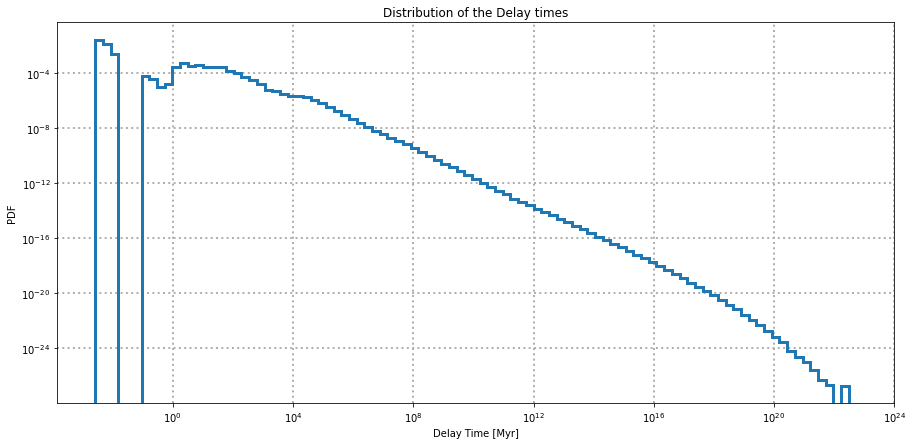

In [13]:
plot_hist(Y_pred, 100)

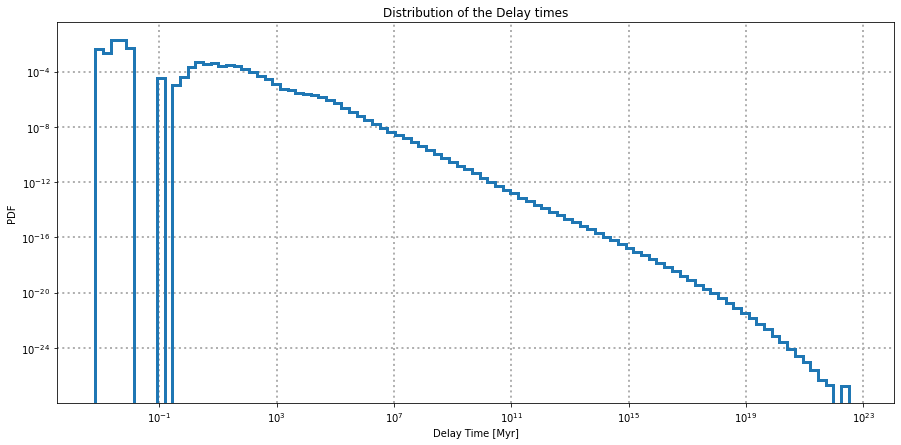

In [14]:
plot_hist(Y_test, 100)

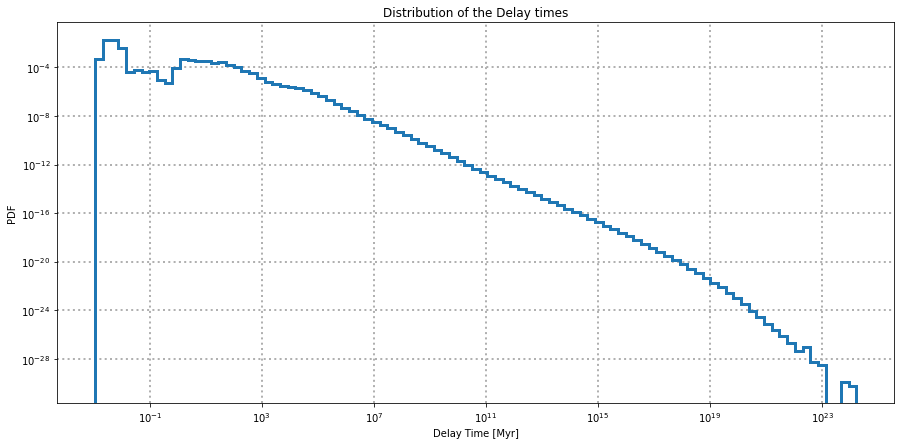

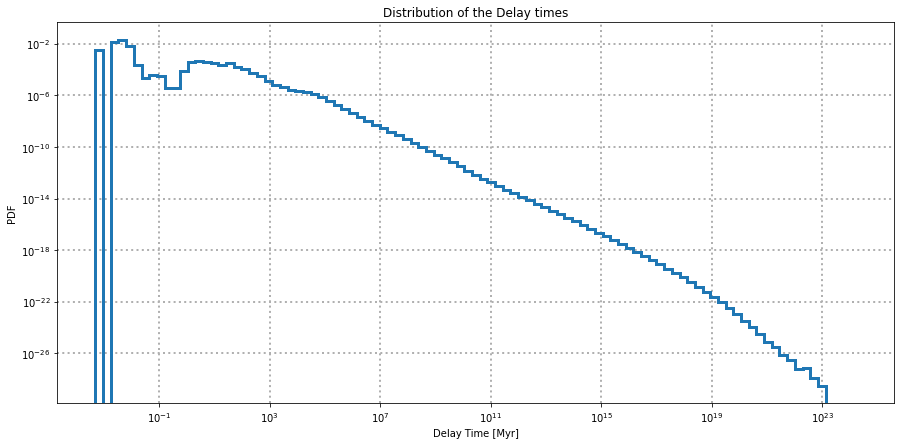

In [15]:
plot_hist(Y_pred2, 100)
plot_hist(Y_test2, 100)

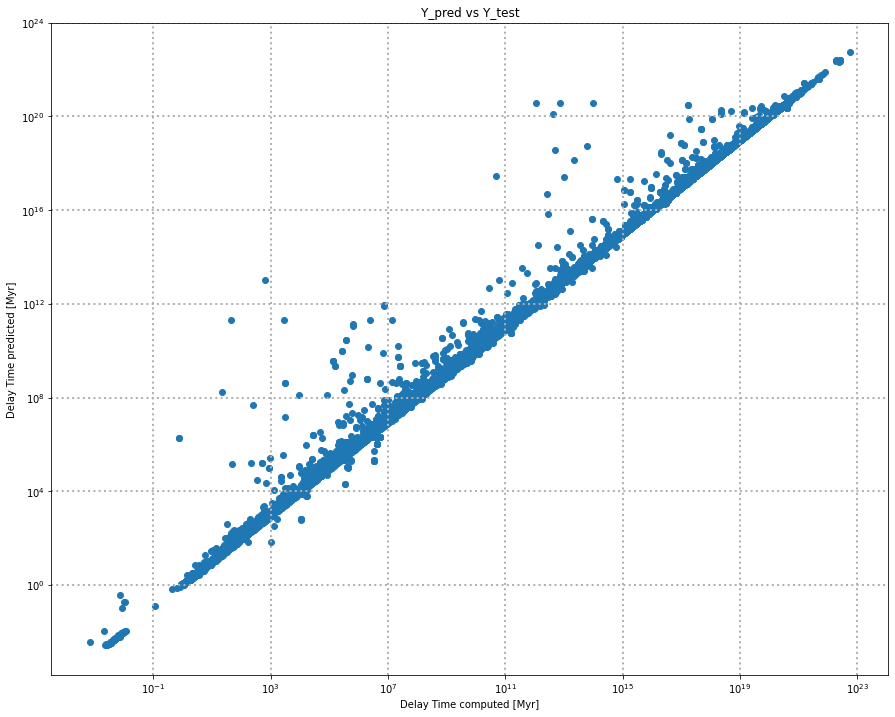

In [16]:
fig, ax = plt.subplots(figsize=(15,12))

ax.scatter(Y_test, Y_pred)

ax.set_title('Y_pred vs Y_test')
ax.set_xlabel('Delay Time computed [Myr]')
ax.set_ylabel('Delay Time predicted [Myr]')
ax.grid(ls='dotted', lw=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

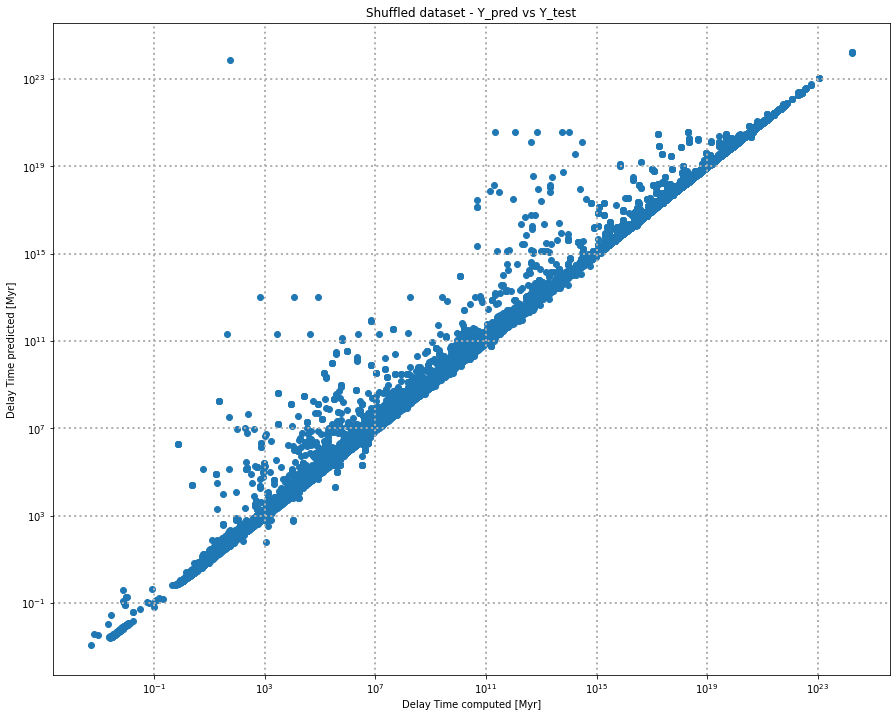

In [17]:
fig, ax = plt.subplots(figsize=(15,12))

ax.scatter(Y_test2, Y_pred2)

ax.set_title('Shuffled dataset - Y_pred vs Y_test')
ax.set_xlabel('Delay Time computed [Myr]')
ax.set_ylabel('Delay Time predicted [Myr]')
ax.grid(ls='dotted', lw=2)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

[0.85254821 0.02267123 0.0206756  0.05879048 0.03619795 0.00911654]


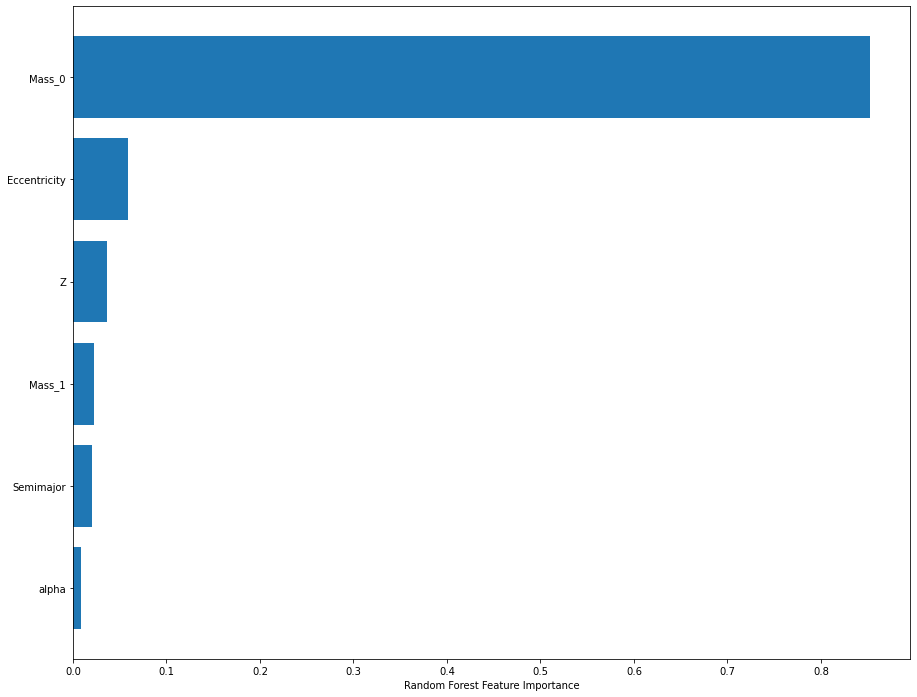

In [18]:
print(regressor.feature_importances_)

features = np.array(['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'])

sorted_idx = regressor.feature_importances_.argsort()

fig, ax = plt.subplots(figsize=(15,12))

ax.barh(features[sorted_idx], regressor.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

plt.show()

In [ ]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(regressor.estimators_[0], 
                   feature_names=['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'],
                   filled=True)

In [ ]:
dot_data = export_graphviz(regressor.estimators_[0],
                           feature_names=['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'],  
                           filled=True, rounded=True)  

graph = graphviz.Source(dot_data, format='png')
graph.render("tree") 

From here it is problematic: using 100 as number of trees and using 30% of the data results in using already almost all the ram (16Gb).

## Tuning of the hyperparameters
First we do a random grid search

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {#'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter = 5, cv = 3, verbose=3, 
                               random_state=42, n_jobs = 1)

# Fit the random search model
with sys_pipes():
    rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5;, score=-22.879 total time=11.2min


In [ ]:
def evaluate_accuracy(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [11]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate_accuracy(best_random, X_test, Y_test)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
best_random

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

## XGBoost

In [6]:
### Normalization of each column
features = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]

# min-max normalization
features = (features-features.min())/(features.max()-features.min())

# mean normalization
#features=(features-features.mean())/features.std()

In [7]:
# define attributes based on knowledge
# should we use the others?
X = features[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y = features.Delay_Time.to_numpy()

# split train and test set (80% training, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=0)
Y_train

array([2.85139799e-20, 1.12481184e-08, 7.20135066e-13, ...,
       2.34295713e-17, 2.71839129e-18, 1.25859401e-21])

In [31]:
# definition of the model 
#model = XGBRFRegressor(
#    objective = 'reg:squarederror',
#    colsample_bytree = 0.9,
#    learning_rate = 1.,
#    max_depth = None,
#    min_child_weight = 1,
#    n_estimators = 50,
#    subsample = 0.9,
#    verbosity=3, 
#    n_jobs=-1,
#    random_state=42)
model = XGBRFRegressor(n_jobs=-1, subsample=.5, colsample_bynode=.5, reg_lambda=1e-05)
# traininig of the model
model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)])

print("Test  R2 Score : %.2f"%model.score(X_test,  Y_test ))
print("Train R2 Score : %.2f"%model.score(X_train, Y_train))

[07:48:00] ======== Monitor (0): Learner ========
[07:48:00] Configure: 0.000187s, 1 calls @ 187us

[07:48:00] ======== Monitor (0): GBTree ========
[07:48:00] ======== Monitor (0): TreePruner ========
[07:48:00] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[07:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=6
[07:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[07:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[07:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[07:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[07:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pr

[07:48:23] ======== Monitor (0): Learner ========
[07:48:23] Configure: 0.000323s, 1 calls @ 323us

[07:48:23] EvalOneIter: 0.028549s, 1 calls @ 28549us

[07:48:23] GetGradient: 0.00621s, 1 calls @ 6210us

[07:48:23] PredictRaw: 0.001429s, 1 calls @ 1429us

[07:48:23] UpdateOneIter: 23.0697s, 1 calls @ 23069702us

[07:48:23] ======== Monitor (0): GBTree ========
[07:48:23] BoostNewTrees: 23.0616s, 1 calls @ 23061576us

[07:48:23] CommitModel: 3e-06s, 1 calls @ 3us

[07:48:23] ======== Monitor (0): TreePruner ========
[07:48:23] PrunerUpdate: 0.008325s, 1 calls @ 8325us

Test  R2 Score : 0.03
Train R2 Score : 0.94


In [14]:
# make predictions to compare with Y_test
Y_pred = model.predict(X_test)

print('Score of the regressor for the training set:\n', model.score(X_train, Y_train))
print('\nScore of the regressor for the test set:\n',   model.score(X_test,  Y_test ))
print('R^2 Score of the regressor for the test set:\n', r2_score(Y_test,  Y_pred ))
print('Mean squared log error of the regressor for the test set:\n', mean_squared_log_error(Y_test,  Y_pred ))
print('Mean squared error of the regressor for the test set:\n', mean_squared_error(Y_test,  Y_pred ))

Score of the regressor for the training set:
 0.988703942732837

Score of the regressor for the test set:
 0.06134236764813317
R^2 Score of the regressor for the test set:
 0.06134236764813317
Mean squared log error of the regressor for the test set:
 7.658943252749947e-09
Mean squared error of the regressor for the test set:
 7.82208387504664e-09


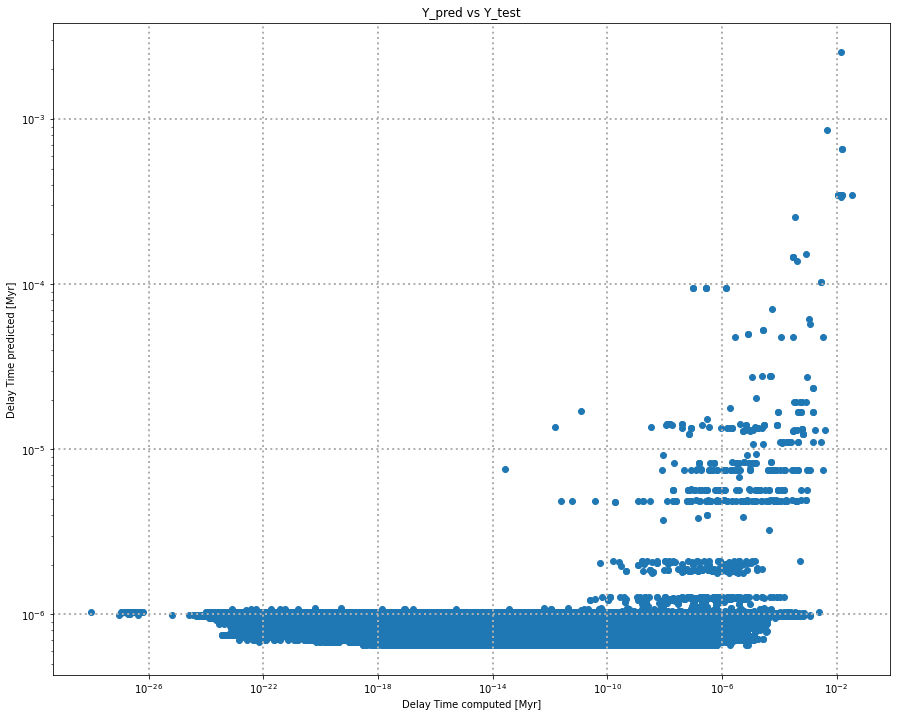

In [15]:
fig, ax = plt.subplots(figsize=(15,12))

ax.scatter(Y_test, Y_pred)

ax.set_title('Y_pred vs Y_test')
ax.set_xlabel('Delay Time computed [Myr]')
ax.set_ylabel('Delay Time predicted [Myr]')
ax.grid(ls='dotted', lw=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

### GridSearch

In [16]:
random_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    #'learning_rate': [.01, .05, .1, .2],
    #'max_depth': [None, 3, 5, 7, 10],
    #'min_child_weight': [None, 1, 3, 5],
    #'subsample': [None, .1, .5, .7],
    #'colsample_bytree': [None, .1, .5, .7],
    #'objective': ['reg:squarederror']
}

random_grid

{'n_estimators': [100, 200, 300, 500, 1000]}

In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = XGBRFRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter = 2, cv = 3, verbose=10, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
with sys_pipes():
    rf_random.fit(X_train, Y_train)
    
    
print("Test  R2 Score : %.2f"%rf_random.score(X_test, Y_test))
print("Train R2 Score : %.2f"%rf_random.score(X_train, Y_train))

print("Best Params : ", rf_random.best_params_)
print("Feature Importances : ")
pd.DataFrame([rf_random.best_estimator_.feature_importances_], columns=['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'])

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

[CV 3/3; 1/2] START n_estimators=200............................................
[CV 3/3; 1/2] END .............n_estimators=200;, score=0.907 total time= 3.2min
[CV 1/3; 1/2] START n_estimators=200............................................
[CV 1/3; 1/2] END ...........n_estimators=200;, score=-60.937 total time= 3.6min
[CV 2/3; 1/2] START n_estimators=200............................................
[CV 2/3; 1/2] END .............n_estimators=200;, score=0.985 total time= 3.6min
[07:12:00] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[07:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[07:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[07:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=6
[07:12:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2

[07:12:46] ======== Monitor (0): Learner ========
[07:12:46] Configure: 0.00168s, 1 calls @ 1680us

[07:12:46] EvalOneIter: 6.3e-05s, 1 calls @ 63us

[07:12:46] GetGradient: 0.007881s, 1 calls @ 7881us

[07:12:46] PredictRaw: 0.001637s, 1 calls @ 1637us

[07:12:46] UpdateOneIter: 45.9114s, 1 calls @ 45911395us

[07:12:46] ======== Monitor (0): GBTree ========
[07:12:46] BoostNewTrees: 45.8992s, 1 calls @ 45899156us

[07:12:46] CommitModel: 3e-06s, 1 calls @ 3us

[07:12:46] ======== Monitor (0): TreePruner ========
[07:12:46] PrunerUpdate: 0.012899s, 1 calls @ 12899us

Test  R2 Score : 0.04
Train R2 Score : 0.99
Best Params :  {'n_estimators': 200}
Feature Importances : 


,Mass_0,Mass_1,Semimajor,Eccentricity,Z,alpha
0,0.633553,0.104929,0.224354,0.037158,0.000006,7.436641e-07


In [18]:
pd.DataFrame.from_dict(rf_random.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,205.736720,11.013889,0.405312,0.087739,200,{'n_estimators': 200},-60.937369,0.985398,0.907379,-19.681530,29.172300,1
1,578.327773,13.377560,0.567292,0.239715,1000,{'n_estimators': 1000},-68.244356,0.985440,0.922325,-22.112197,32.620373,2


### Using Tensorflow

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
"""### Normalization over the whole dataset

features_all = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]

min_value = np.min (np.min (features_all, axis=0))
max_value = np.max (np.max (features_all, axis=0))
avg_value = np.mean(np.mean(features_all, axis=0))
std_value = np.std (np.std (features_all, axis=0))

method = 'norm'  #norm, std, log

def normalizer(x):
    if method == 'norm':
        return (x-min_value)/(max_value-min_value)
    elif method =='std':
        return (x- avg_value)/std_value
    elif method =='log':
        return np.log10(x)

features_all = features_all.apply(normalizer)"""

### Normalization of the data

In [ ]:
### Normalization of each column
features = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]

# min-max normalization
features = (features-features.min())/(features.max()-features.min())

# mean normalization
#features=(features-features.mean())/features.std()

### Split in training and validation

In [ ]:
# Split the dataset into a training and a testing dataset.
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [ ]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset=features,
                                        test_ratio=.5)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))

In [ ]:
X_train = train_ds_pd[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y_train = train_ds_pd.Delay_Time.to_numpy()

X_test  = test_ds_pd[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y_test  = test_ds_pd.Delay_Time.to_numpy()

### Training of the model

In [ ]:
# Configure the model.
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, num_threads=n_threads)
# Configure the metrics (Eventually add other metrics).
#model.compile(metrics=["mse", "mape"])
model.compile(metrics=["mse"])
# Train the model.
with sys_pipes():
    #model.fit(x=train_ds)
    model.fit(X_train, Y_train)

In [ ]:
model.summary()

In [ ]:
# inspect the features used in the model
model.make_inspector().features()

In [ ]:
#evaluation = model.evaluate(test_ds, return_dict=True)
evaluation = model.evaluate(X_test, Y_test, return_dict=True)

print(evaluation)
print(f"MSE: {evaluation['mse']:.2f}")
print(f"RMSE: {np.sqrt(evaluation['mse']):.2f}")
#print(f"MAPE: {evaluation['mape']:.2f}")

In [ ]:
logs = model.make_inspector().training_logs()

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12, 12))

ax[0,0].plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
ax[0,0].set_xlabel("Number of trees")
ax[0,0].set_ylabel("Accuracy (out-of-bag)")
ax[0,1].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
ax[0,1].set_xlabel("Number of trees")
ax[0,1].set_ylabel("Logloss (out-of-bag)")
ax[1,0].plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
ax[1,0].set_xlabel("Number of trees")
ax[1,0].set_ylabel("Accuracy (out-of-bag)")
ax[1,1].plot([log.num_trees for log in logs], [log.evaluation.ndcg for log in logs])
ax[1,1].set_xlabel("Number of trees")
ax[1,1].set_ylabel("Logloss (out-of-bag)")
plt.show()


# ????
# Why loss and accuracy are zero?
# Maybe something missing

In [ ]:
# make predictions to compare with Y_test
#Y_pred = model.predict(test_ds)
Y_pred = model.predict(X_test)

In [ ]:
(Y_pred, Y_test)

In [ ]:
epsilon = 1e-28

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(Y_test)+epsilon), np.log10(max(Y_test)), 100)
entries, edges, _ = ax.hist(Y_test, bins=b, density=True, histtype='step', lw=3)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted', lw=2)

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(Y_pred)), np.log10(max(Y_pred)), 100)
b = np.concatenate(b, axis=0)
entries, edges, _ = ax.hist(Y_pred, bins=b, density=True, histtype='step', lw=3)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted', lw=2)

In [ ]:
# plot the first tree, restricted to depth of 3
tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3)

In [ ]:
# Number of trees in random forest
num_trees = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
num_candidate_attributes = [-1, 0, 3]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_examples = [2, 5, 10, 50]

# Minimum number of samples required at each leaf node
uplift_min_examples_in_treatment = [1, 2, 4, 5, 10]

# Method of selecting samples for training each tree
adapt_bootstrap_size_ratio_for_maximum_training_duration = [True, False]

# Create the random grid
random_grid = {'num_trees': num_trees,
               'num_candidate_attributes': num_candidate_attributes,
               'max_depth': max_depth,
               'min_examples': min_examples,
               'uplift_min_examples_in_treatment': uplift_min_examples_in_treatment,
               'adapt_bootstrap_size_ratio_for_maximum_training_duration': adapt_bootstrap_size_ratio_for_maximum_training_duration}
random_grid

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = KerasClassifier(model=tfdf.keras.RandomForestModel, task = tfdf.keras.Task.REGRESSION, num_threads=n_threads)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               scoring='accuracy',
                               n_iter = 20, cv = 3, verbose=0, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, Y_train)

In [ ]:
"""for deeptnote"""
# def slice_dataset(dataset, slice_ratio=0.15):
#   valid_indices = np.random.rand(len(dataset)) < slice_ratio
#   return dataset[valid_indices]
# BHBH_sliced = slice_dataset(BHBH)
# BHBH_sliced.to_csv('dataset.csv')